# Minimization procedure to estimate the orientation of the crystal

> **Goal**: Describe the minimization protocol using Scipy's curve_fit to estimate the orientation of the transmission envelope and by extension of the crystal in an imposed reference frame.

To estimate the full orientation of a crystal with respect to a given reference frame we need to consider 
 
1. how the transmittance envelope is oriented with respect to the reference frame  
2. how the crystal's reference frame (e.g. its axes) is oriented with respect to the transmittance envelope.  

In addition, we will need several functions to handle the transformation from polar to Cartesian coordinates and vice versa or transformations between the different representations of 3D Cartesian rotations.

In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.spatial.transform import Rotation as r
from scipy.optimize import curve_fit

# Explanation of the Scipy's ``curve_fit`` fitting procedure 

The ``curve_fit`` procedure uses a non-linear least squares approach to fit a function f to data using the following inputs (as a minimum):

- the first input is the function to optimize. The function must take the independent variable as the first input and the parameters to fit as separate remaining inputs. The return of the function should be the dependent data.
- the second input (xdata) is the independent data/variable
- the third input (ydata) is the dependent data/variable

> link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In our problem and as a first step, we want to find the orientation of a crystal from a few transmittance measurements with respect to a reference frame. For this, we need first to establish a reference frame between the transmittance envelope and or fixed reference frame (the microscope, the sample or both). Once this is done, it is a matter of finding the rotation matrix that converts the transmittance coordinates linked to our fixed reference frame (calculated theoretically) to the transmittance coordinates measured in that same reference frame. (see notebook on reference frames for more details). Then, the equation to solve will be of the following type:

$$
y_{data} = R \cdot x_{data}
$$

where
- $x_{data}$ are the cartesian coordinates $(x,y,z)$ of the points/object used as reference frame (i.e. calculated theoretically using the transmittance equation and the reference frame). For convenience, it will be the cartesian coordinates of the points when Euler angles are [0,0,0] (Bunge convention) for a specified sample thickness and wavelenght.
- $y_{data}$ are the transformed cartesian coordinates $(x,y,z)$ of the points/object calculated by measuring the transmitance at different polar coordinates in the microscopy (i.e. what we actually measure)
- $R$ is the rotation matrix that convert $x_{data}$ into $y_{data}$ defining the orientation of the transmittance envelope with respect to our reference frame. This is the parameter to optimize.

TODO



## Range of possible Euler values (Bunge convention) to fit

The transmission envelope has an orthorhombic symmetry. In the Bunge convention and for intrinsic rotations, the minimum range of Euler angles to define any orientation of an orthorhombic summetry (space group Pbnm) are:

$0^{\circ} \leq \varphi_{1} < 90^{\circ}$    
$0^{\circ} \leq \varphi_{2} < 180^{\circ}$  
$0^{\circ} \leq \varphi_{3} < 90^{\circ}$  

> Intrinsic rotations means that these Euler angles describe the rotations that are needed to align the crystal/object with a reference frame where the symmetry elements of the crystal are in a fixed position. See https://github.com/bertopadron/FTIR-EBSD/blob/main/notebooks2learn/Scipy_rotation_module.ipynb for more details

Let's check this:

In [2]:
# define some neccesary funtions
def sph2cart(phi, theta, T):
    """ Convert from spherical/polar (phi, thetha) to cartesian
    coordinates.

    Parameters
    ----------
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis
    T : int or float
        the magnitud of the vector (rho) in polar coordinates

    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the x, y, and z coordinates
    """
    
    x = T * np.sin(phi) * np.cos(theta)
    y = T * np.sin(phi) * np.sin(theta)
    z = T * np.cos(phi)
    
    return x, y, z


def Tvalues(trans, phi, theta):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    phi : int or float between 0 and 90
        angle respect to the c-axis
    theta : int or float between 0 and 360
        angle respect to the a-axis

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(theta)**2 * np.sin(phi)**2 + \
           Tb * np.sin(theta)**2 * np.sin(phi)**2 + \
           Tc * np.cos(phi)**2

def rotate(coordinates, euler_ang):
    """ Rotate points in 3D cartesian space using the Bunge convention
    in degrees with intrinsic rotation. This is just a wrapper for the
    r.from_euler() Scipy method for convenience

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = r.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]

In [3]:
# generate a mesh of spherical/polar coordinates
theta = np.linspace(0, 2*np.pi, 100)
phi = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # in this case np.linspace goes from 0 to 1 (not pi)!
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# create rotations to check the assumtion
# rotations around phi 1
rotation_0 = rotate(coordinates=(x, y, z), euler_ang=(45, 0, 0))
rotation_1 = rotate(coordinates=(x, y, z), euler_ang=(90, 0, 0))
# rotations around phi 2
rotation_2 = rotate(coordinates=(x, y, z), euler_ang=(0, 45, 0))
rotation_3 = rotate(coordinates=(x, y, z), euler_ang=(0, 90, 0))
rotation_4 = rotate(coordinates=(x, y, z), euler_ang=(0, 180, 0))
# combined rotations
rotation_5 = rotate(coordinates=(x, y, z), euler_ang=(90, 90, 0))
rotation_6 = rotate(coordinates=(x, y, z), euler_ang=(0, 90, 90))
rotation_7 = rotate(coordinates=(x, y, z), euler_ang=(90, 180, 90))

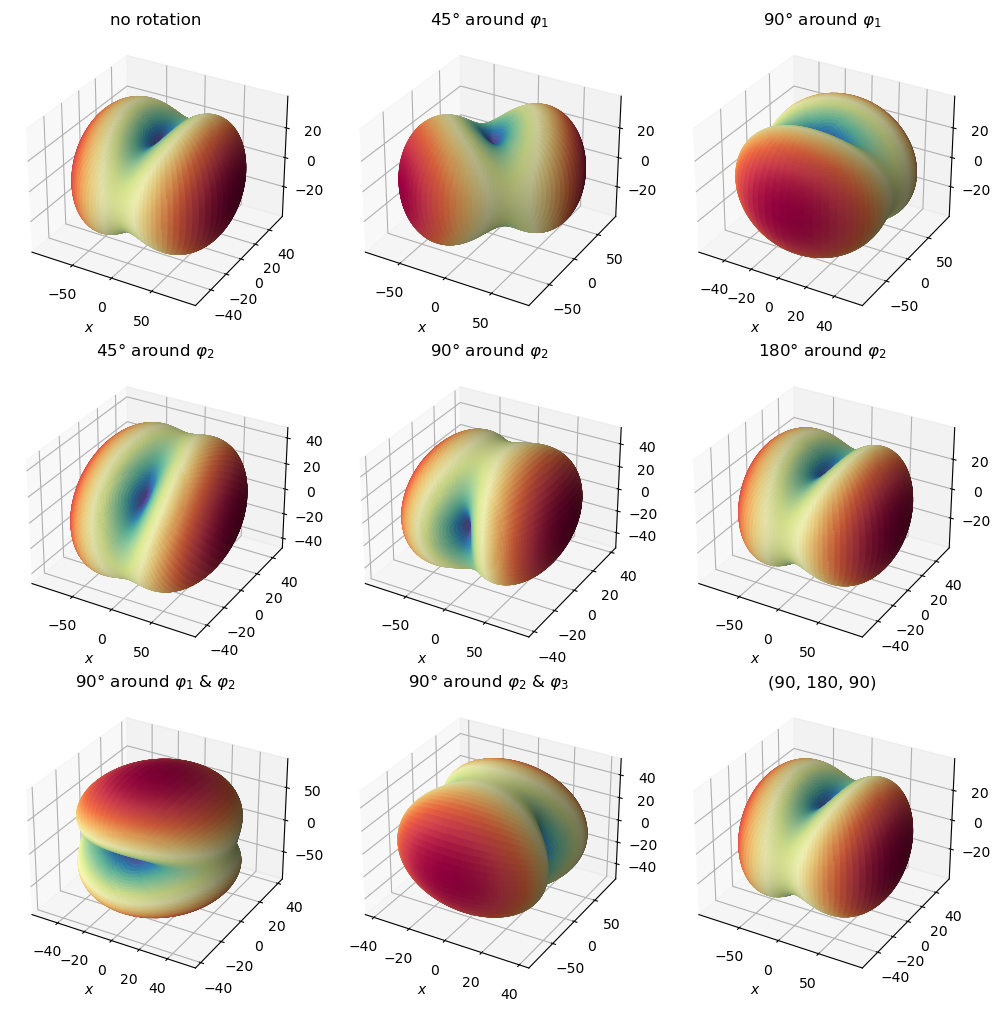

In [4]:
# make plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10), subplot_kw={"projection": "3d"}, constrained_layout=True)

# first row: rotations around phi 1
axes[0,0].plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,0].set_xlabel(r'$x$')
axes[0,0].set_title('no rotation')

axes[0,1].plot_surface(rotation_0[0], rotation_0[1], rotation_0[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,1].set_xlabel(r'$x$')
axes[0,1].set_title(r'45° around $\varphi_{1}$')

axes[0,2].plot_surface(rotation_1[0], rotation_1[1], rotation_1[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[0,2].set_xlabel(r'$x$')
axes[0,2].set_title(r'90° around $\varphi_{1}$')

# second row: rotations around phi 2
axes[1,0].plot_surface(rotation_2[0], rotation_2[1], rotation_2[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,0].set_xlabel(r'$x$')
axes[1,0].set_title(r'45° around $\varphi_{2}$')

axes[1,1].plot_surface(rotation_3[0], rotation_3[1], rotation_3[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,1].set_xlabel(r'$x$')
axes[1,1].set_title(r'90° around $\varphi_{2}$')

axes[1,2].plot_surface(rotation_4[0], rotation_4[1], rotation_4[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[1,2].set_xlabel(r'$x$')
axes[1,2].set_title(r'180° around $\varphi_{2}$')

# third row: combined rotations
axes[2,0].plot_surface(rotation_5[0], rotation_5[1], rotation_5[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,0].set_xlabel(r'$x$')
axes[2,0].set_title(r'90° around $\varphi_{1}$ & $\varphi_{2}$')

axes[2,1].plot_surface(rotation_6[0], rotation_6[1], rotation_6[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,1].set_xlabel(r'$x$')
axes[2,1].set_title(r'90° around $\varphi_{2}$ & $\varphi_{3}$')

axes[2,2].plot_surface(rotation_7[0], rotation_7[1], rotation_7[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
axes[2,2].set_xlabel(r'$x$')
_ = axes[2,2].set_title(r'(90, 180, 90)')

## Tests using exact solutions (no errors in the datapoints)



In [5]:
def func(ref_coordinates, a, b, c):
    """ Function to minimize

    Parameters
    ----------
    ref_coordinates : array-like
        a numpy 1d array containing the Cartesian coordinates
        x, y and z (in that order) of the points.
    a : _type_
        _description_
    b : _type_
        _description_
    c : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    # check that the array is a multiple of 3
    if ref_coordinates.size % 3 != 0:
        raise ValueError("ref_coordinates must be multiples of 3!")

    # define a rotation in euler space (Bunge) and intrinsic rotations
    rotation = r.from_euler('zxz', [a, b, c], degrees=True)

    # reshape (x, y, z) coordinates to apply rotation
    # it must have a shape of (1, n, 3)
    n = int(ref_coordinates.size / 3)
    coordinates = ref_coordinates.reshape(1, n, 3)

    # apply rotation
    guess_coordinates = coordinates @ rotation.as_matrix().T

    return guess_coordinates.flatten()

### First example

Generate a toy dataset to test

In [6]:
# create a generator of random numbers
rng = np.random.default_rng()

# generate random spherical/polar coordinates (just 5x5=25)
np.random.seed(218)  # this is just for reproducibility (generates random number based on seed. Seed can be any number), comment if you want to generate different toy datasets
phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=5))
theta = rng.uniform(low=0, high=2*np.pi, size=5)
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

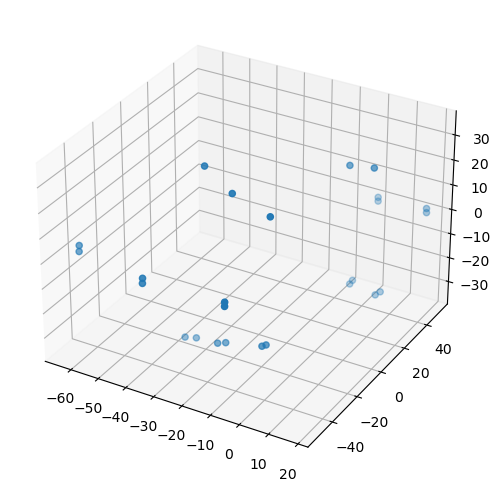

In [7]:
# check making a plot
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)

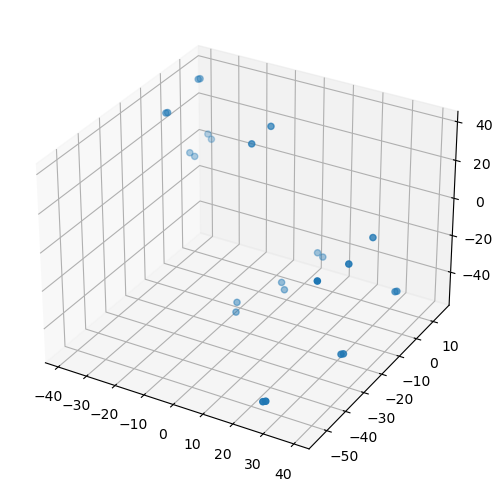

In [8]:
# rotate data. Euler angles (30, 45, 60)
rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(30, 45, 60))

# check making a plot
fig4, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(rot_x, rot_y, rot_z)

In [9]:
# find a solution

# stack coordinates. this will not be necessary once the refactoring is done
ref_coordinates = np.dstack((x, y, z))
rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

# test curve_fit
popt, pcov = curve_fit(func,
                       xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                       ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                       p0=(45, 90, 45),                      # initial guess for euler angles (it didn't work when using (0,0,0))
                       bounds=((0, 0, 0), (90, 180, 90)))    # Euler angle bounds for the orthorhombic symmetry

In [10]:
# plot the solution
popt

array([30., 45., 60.])

Voila, the exact result.

> In the first attempts the procedure failed because ``curve_fit()``, and thus ``least_squares()``, expect that the function returns a 1-d array, i.e. of shape ``(n,)``. So, we need to flatten/ravel de n-dim arrays that represents the indepent and dependent data into 1-d arrays to make it work.

### First test: same solution different datapoints (sample size fixed to 10; number of test 15)

In [11]:
for i in range(15):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=10))
    theta = rng.uniform(low=0, high=2*np.pi, size=10)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(15, 42, 40))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))    # bounds
    
    print(popt)
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')


[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
[15. 42. 40.]
DONE


### Same solution (euler angles) but different sample size

In [12]:
size = [10, 9, 8, 7, 6, 5, 4, 3, 2]

for i in range(len(size)):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=size[i]))
    theta = rng.uniform(low=0, high=2*np.pi, size=size[i])

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates (independent data)
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points (dependent data)
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(15, 42, 40))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(), 
                           ydata=rot_coordinates.flatten(),   
                           p0=(45, 90, 45),
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(f'n = {size[i]}; {popt}')
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

n = 10; [15. 42. 40.]
n = 9; [15. 42. 40.]
n = 8; [15. 42. 40.]
n = 7; [15. 42. 40.]
n = 6; [15. 42. 40.]
n = 5; [15. 42. 40.]
n = 4; [15. 42. 40.]
n = 3; [15. 42. 40.]
n = 2; [15. 42. 40.]
DONE


## Different solutions (random euler angles) same sample size (n=5) 

In [13]:
for i in range(100):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=5))
    theta = rng.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # generate random euler angle values
    a = np.random.randint(low=0, high=90)
    b = np.random.randint(low=0, high=180)
    c = np.random.randint(low=0, high=90)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(a, b, c))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(f"Real = ({a}, {b}, {c}); estimated = {popt}")
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

Real = (77, 102, 14); estimated = [ 77. 102.  14.]
Real = (56, 100, 73); estimated = [ 56. 100.  73.]
Real = (61, 67, 41); estimated = [61. 67. 41.]
Real = (38, 40, 47); estimated = [38. 40. 47.]
Real = (43, 160, 26); estimated = [ 43. 160.  26.]
Real = (68, 104, 7); estimated = [ 68. 104.   7.]
Real = (11, 153, 3); estimated = [ 11. 153.   3.]
Real = (78, 143, 44); estimated = [ 78. 143.  44.]
Real = (41, 140, 34); estimated = [ 41. 140.  34.]
Real = (61, 145, 62); estimated = [ 61. 145.  62.]
Real = (89, 70, 76); estimated = [89. 70. 76.]
Real = (48, 117, 53); estimated = [ 48. 117.  53.]
Real = (3, 129, 59); estimated = [  3. 129.  59.]
Real = (51, 111, 1); estimated = [ 51. 111.   1.]
Real = (23, 31, 87); estimated = [23. 31. 87.]
Real = (4, 170, 1); estimated = [  4. 170.   1.]
Real = (65, 58, 1); estimated = [65. 58.  1.]
Real = (26, 153, 41); estimated = [ 26. 153.  41.]
Real = (31, 140, 67); estimated = [ 31. 140.  67.]
Real = (0, 93, 30); estimated = [2.96134306e-05 9.30000277

## Test limit cases: euler angles = (0,0,0) & (90, 180, 90) (n=5, no errors in the datapoints)

Actually both limit cases represent the same crystal orientation

In [14]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=10))
    theta = rng.uniform(low=0, high=2*np.pi, size=10)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(0, 0, 0))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
DONE


For the (0, 0, 0) limit case it holds.

In [15]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * rng.uniform(low=0, high=1, size=5))
    theta = rng.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(90, 180, 90))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[ 18.9 180.   18.9]
[ 37.3 180.   37.3]
[  4.1 180.    4.1]
[ 82.2 180.   82.2]
[  5.8 180.    5.8]
[ 44.6 180.   44.6]
[  0.6 180.    0.6]
[ 88.7 180.   88.7]
[ 50. 180.  50.]
[ 59.6 180.   59.6]
DONE


In this case, the optimization fails because of the Gimbal lock issue which is a special case that occurs when the second Euler angle is at one of its limits and the method loss one degree of freedom. A workaround should be to handle this changing the limit angle value of 180 for a close enough value (e.g. 179.99). Let's explore this:

In [16]:
for i in range(10):
    # generate random spherical/polar coordinates
    phi = np.arccos(1 - 2 * np.random.uniform(low=0, high=1, size=5))
    theta = np.random.uniform(low=0, high=2*np.pi, size=5)

    # estimate T values
    T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

    # convert from spherical to cartesian coordinates
    x, y, z = sph2cart(phi, theta, T)

    # get the coordinates of the rotated points
    rot_x, rot_y, rot_z = rotate(coordinates=(x, y, z), euler_ang=(90, 179.99, 90))
    
    # stack coordinates
    ref_coordinates = np.dstack((x, y, z))
    rot_coordinates = np.dstack((rot_x, rot_y, rot_z))

    # test curve_fit
    popt, pcov = curve_fit(func,
                           xdata=ref_coordinates.flatten(),      # independent data (array flattened)
                           ydata=rot_coordinates.flatten(),      # dependent data (array flattened)
                           p0=(45, 90, 45),                      # initial guess for euler angles
                           bounds=((0, 0, 0), (90, 180, 90)))
    
    print(np.around(popt, decimals=1))
    #print(np.sqrt(np.diag(pcov)))
    #print('')

print('DONE')

[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
[ 90. 180.  90.]
DONE


In [17]:
import sys
import scipy as sp
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Scipy', sp.__version__)

Notebook tested in 2023-02-10 using:
Python 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Numpy 1.23.5
Scipy 1.10.0
